In [11]:
import os
import cv2 
import scipy as sp
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import glob
import itertools

In [12]:
import xml.etree.ElementTree as ET
from lxml import etree

def get_points(xml_data):
    tree = etree.parse(xml_data)
    root = tree.getroot()
    parking = {"id":[], "occupied":[], "points":[], "rects":[]}
    for elem in root.iter("space"):
        space_points = []
        space_rects = []
        parking["id"].append(int(elem.attrib["id"]))
        try:
            parking["occupied"].append(int(elem.attrib["occupied"]))
        except:
            parking["occupied"].append(None)
            
        points_list = elem.xpath("contour/point")
        for p in points_list:
            space_points.append([int(p.attrib["x"]), int(p.attrib["y"])])
        parking["points"].append(space_points)
        
        rotatedRect = elem.xpath("rotatedRect")[0]
        for r in rotatedRect:
            if r.tag == "angle":
                space_rects.append(int(r.attrib["d"]))
            else:
                space_rects.append(tuple([int(e) for e in r.attrib.values()]))
        parking["rects"].append(tuple(space_rects))

    assert len(parking["id"]) == len(parking["occupied"]) == len(parking["points"]) == len(parking["rects"])
    return parking

In [13]:
def rotate_crop_image(mat, rect):
    (x, y) = rect[0]
    (w, h) = rect[1]
    angle = rect[2]
    w = int(w/2)
    h = int(h/2)
    if angle < -45:
        angle += 90
        w, h = h, w

    height, width = mat.shape[:2]
    image_center = (x, y)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    
    croppes_mat = rotated_mat[y-h: y + h, x-w: x + w]
    return np.array(croppes_mat)

In [14]:
from skimage import feature
import numpy as np

#‘default’: original local binary pattern which is gray scale but not rotation invariant.
#‘ror’: extension of default implementation which is gray scale and rotation invariant.
#‘uniform’: improved rotation invariance with uniform patterns and finer quantization of the angular space which is gray scale and rotation invariant.
#‘nri_uniform’: non rotation-invariant uniform patterns variant which is only gray scale invariant.
#‘var’: rotation invariant variance measures of the contrast of local image texture which is rotation but not gray scale invariant.

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius
        
    def lbp(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        return lbp

    def describe(self, image, eps=1e-7):

        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist

In [15]:
import imageio
from PIL import Image

#convert to numpy array
def load_img(filename):
    return np.array(Image.open(filename))

def create_gaussian_kernel(size, sigma = 1.0):
    
    #Buat dimensi gaussian kernel: size*size
    #size harus angka ganjil
    
    if(size%2==0):
        raise ValueError("Size must be an odd number")
    
    x, y = np.meshgrid(np.linspace(-2, 2, size, dtype=np.float32), np.linspace(-2, 2, size, dtype=np.float32))
    
    rv = (np.exp(-(x ** 2 + y ** 2) / (2.0 * sigma ** 2))) / (2.0 * np.pi * sigma ** 2)
    
    rv = rv / np.sum(rv)
    
    return rv

def convolve_pixel(img, kernel, i, j):
    
    # convolves kernel gambar pixel di (i, j). mengembalikan piksel asli
    # jika kernel melampaui batas gambar
    
    if(len(img.shape)!=2):
        raise ValueError("Input image should be single chanelled")
    if(len(kernel.shape)!=2):
        raise ValueError("kernel should be two dimensional")
    
    k = kernel.shape[0]//2
    
    # memeriksa apakah kernel berada di luar perbatasan
    if i < k or j < k or i >= img.shape[0]-k or j >= img.shape[1]-k:
        return img[i, j]
    
    else:
        value = 0
        for u in range(-k,k+1):
            for v in range(-k,k+1):
                value += img[i-u][j-v] * kernel[k+u][k+v]
        
        return value
    
def convolve(img, kernel):
    
    # mengembalikan gambar yang convoluted dalam variabel baru
    # kernel harus memiliki dimensi ganjil dan gambar harus saluran tunggal dan ndarray dua dim
    
    new_img = np.array(img)     #membuat salinan dari gambar asli di mana nanti akan mengembalikan hasilnya
    
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            new_img[i][j] = convolve_pixel(img, kernel, i, j)
            
    return new_img

def split(img):
    
    # splits image into 3 ndarrays, one for each channel (R,G,B)
    if img.shape[2] != 3:
        raise ValueError('The split function requires a 3-channel input image')
    return img[:, :, 0], img[:, :, 1], img[:, :, 2]
            
def merge(r,g,b):
    return np.dstack((r, g, b))

kernel = create_gaussian_kernel(3,3)
print(kernel)

img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#001.jpg")
#(r,g,b) = split(img)
#r = convolve(r, kernel)
#g = convolve(g, kernel)
#b = convolve(b, kernel)
#blur = merge(r,g,b)

#plt.imshow(blur)

[[0.09474166 0.11831801 0.09474166]
 [0.11831801 0.14776132 0.11831801]
 [0.09474166 0.11831801 0.09474166]]


In [16]:
def adjust_gamma(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [17]:
class lbpuniform:
    def create_index(s_T):
        n_ones = np.sum(s_T)
        s_T_size = len(s_T)

        if 1 in s_T:
            first_one = list(s_T).index(1)
        else:
            first_one = -1

        if 0 in s_T:
            first_zero = list(s_T).index(0)
        else:
            first_zero = -1

        if n_ones == 0:
            return 0
        elif n_ones == s_T_size:
            return s_T_size * (s_T_size - 1) + 1
        else:
            if first_one == 0:
                rot_index = n_ones - first_zero
            else:
                rot_index = s_T_size - first_one
            return 1 + (n_ones - 1) * s_T_size + rot_index
    
    def neighborhood(P, R):
        x = np.arange(0, P)
        x = R * np.cos(2 * np.pi * x / P)

        y = np.arange(0, P)
        y = - R * np.sin(2 * np.pi * y / P)

        return x, y
    
    def interpolate2d(gray_img, kind='cubic'):
        """
        Returns a function f(x,y) that returns the interpolated value
        of gray_img where (x,y) is the coordinate.
        """
        assert gray_img.ndim == 2, 'It should be a two dimentional image (gray)'
        h, w = gray_img.shape

        x = np.arange(0, w)
        y = np.arange(0, h)

        return interpolate.interp2d(x, y, gray_img, kind=kind)
    
    def calculate_neiborhood_values(x, y, interpolation_function):
        gray_values = map(lambda pt: interpolation_function(*pt), zip(x, y))
        return np.fromiter(gray_values, float)
    
    def joint_difference_distribution(gray_img, gc, x, y, interpolation_f):
        xc, yc = gc
        xp = xc + x
        yp = yc + y
        g_p = lbpuniform.calculate_neiborhood_values(xp, yp, interpolation_f)
        g_c = interpolation_f(xc, yc)
        return np.round(g_p - g_c, 15)

    
    def binary_joint_distribution(gray_img, gc, x, y, interpolation_f):
        T = lbpuniform.joint_difference_distribution(gray_img, gc, x, y, interpolation_f)
        return np.where(T >= 0, 1, 0)

    def LBP(gray_img, gc, x, y, interpolation_f):
        s = lbpuniform.binary_joint_distribution(gray_img, gc, x, y, interpolation_f)
        p = np.arange(0, P)
        binomial_factor = 2 ** p
        return np.sum(binomial_factor * s) 

    def is_uniform(pattern):
        count = 0
        for idx in range(len(pattern) - 1):
            count += pattern[idx] ^ pattern[idx + 1]
            if count > 2:
                return False
        return True

    def uniform_patterns(P):
        patterns = itertools.product([0, 1], repeat=P)
        u_patterns = [pattern for pattern in patterns if lbpuniform.is_uniform(pattern)]

        return [''.join(str(elem) for elem in elems) for elems in u_patterns]

    def LBP_uniform(gray_img, gc, x, y, interpolation_f, uniform_patterns):
        s = lbpuniform.binary_joint_distribution(gray_img, gc, x, y, f)
        pattern = ''.join([str(elem) for elem in s])

        return lbpuniform.create_index(s) if pattern in uniform_patterns else 2 + P * (P - 1)

[   4   42    9  653 1173 3424  302  478 1590   47]


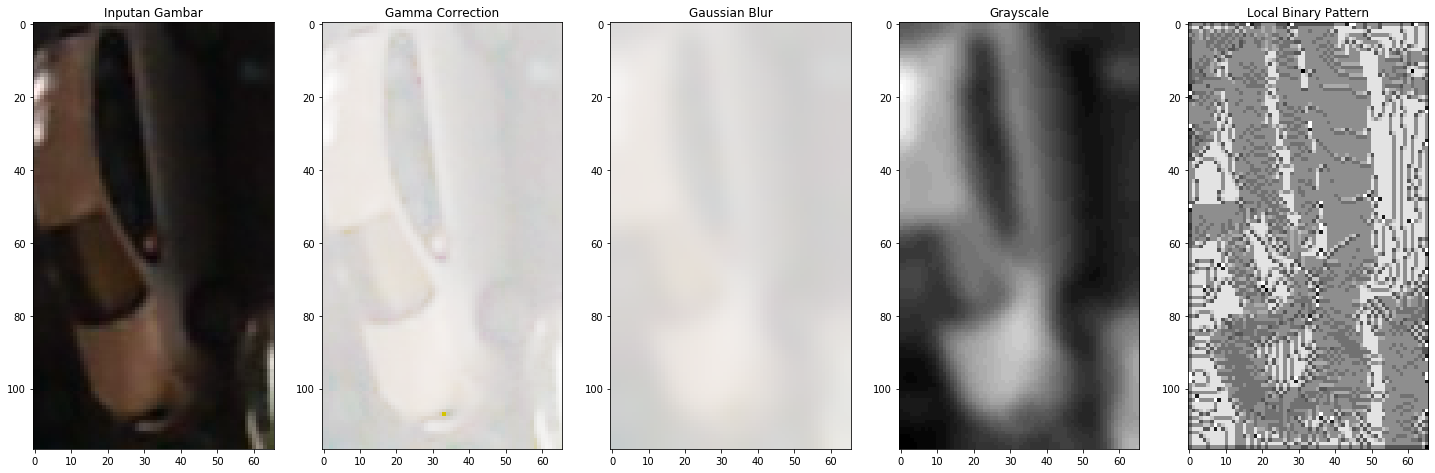

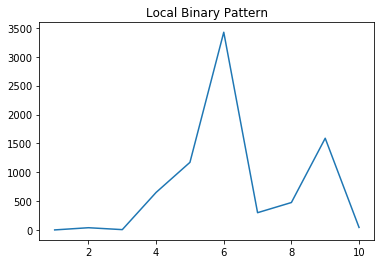

In [18]:
from skimage.exposure import histogram
from matplotlib.pyplot import figure



#Empty Spot
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#001.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#002.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#003.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#004.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#005.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#006.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#007.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#008.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#009.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#010.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#011.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#012.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#013.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#014.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#015.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#016.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#017.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#018.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#019.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#020.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#021.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#022.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#023.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#024.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#025.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#026.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#027.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#028.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#029.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#030.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#031.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#032.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#033.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#034.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#035.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#036.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#037.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#038.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#039.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-03-03/Empty/2013-03-03_06_05_00#040.jpg")



#Occupied Spot
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#001.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#002.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#003.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#004.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#005.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#006.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#007.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#008.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#009.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#010.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#011.jpg")#beda
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#012.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#013.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#014.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#015.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#016.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#017.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#018.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#019.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#020.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#021.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#022.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#023.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#024.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#025.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#026.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#027.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#028.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#029.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#030.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#031.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#032.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#033.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#034.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#035.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#036.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#037.jpg")
#mg = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#038.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#039.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking\PKLot/PKLot Segmented/UFPR05/Training/Cloudy/2013-02-26/Occupied/2013-02-26_13_24_34#040.jpg")
#print(imgs.shape) #baris,kolom, kanal warna
img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Sunny/2013-03-02/Occupied/2013-03-02_09_25_04#030.jpg")

#Analisa Kesalahan Deteksi
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_0.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_2.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_2.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_3.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_4.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_5.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_6.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_7.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_8.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_9.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_10.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_11.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_12.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_13.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_14.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_15.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_16.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_17.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_18.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_19.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_21.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Poly/image_138.jpg")
#img = cv2.imread("Z:/Pemrograman/TASmartParking/Fail/Rbf/image_108.jpg")

#img = cv2.imread("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/Rainy/2013-02-26/Occupied/2013-02-26_13_19_33#004.jpg")

P = 8
desc = LocalBinaryPatterns(8, 1)
#kernel = create_gaussian_kernel(3,3)

gamcor = adjust_gamma(img, 15)
#(r,g,b) = split(gamcor)
#r = convolve(r, kernel)
#g = convolve(g, kernel)
#b = convolve(b, kernel)
#blur = merge(r,g,b)
blur = cv2.GaussianBlur(gamcor,None,3)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
lbp = desc.lbp(gray)
ravel = lbp.ravel()
np.savetxt('data.csv', ravel, delimiter=',')
h = desc.describe(gray)
#plt.hist(h)
hist, bins = np.histogram(lbp.ravel(),bins=np.arange(0, P + 3), range=(0, P + 2))
print(hist)

f = plt.figure(figsize=(25,25))
f.add_subplot(1,5, 1)
plt.imshow(np.rot90(img,2))
plt.title("Inputan Gambar")
f.add_subplot(1,5, 2)
plt.imshow(np.rot90(gamcor,2))
plt.title("Gamma Correction")
f.add_subplot(1,5, 3)
plt.imshow(np.rot90(blur,2))
plt.title("Gaussian Blur")
f.add_subplot(1,5, 4)
plt.imshow(np.rot90(gray,2), cmap="gray")
plt.title("Grayscale")
f.add_subplot(1,5, 5)
plt.imshow(np.rot90(lbp,2), cmap="gray")
plt.title("Local Binary Pattern")


plt.show(block=True)

plt.plot(bins[1: ], hist)
plt.title("Local Binary Pattern")
plt.show()
#plt.hist(h)

cv2.imwrite("lbpoutput.jpg",lbp)

plt.show()

In [19]:
import glob

data = []
targets = []
I = 0
for f_path in glob.glob("Z:/Pemrograman/TASmartParking/PKLot/PKLot Segmented/UFPR05/Training/**/*.jpg", recursive=True):
    I += 1
    if I % 1000 == 0:
        print("Loaded " + str(I) + " images.")
    tgt = int("Occupied" in f_path)
    img = cv2.imread(f_path)
    img = np.array(img)
    gamcor = adjust_gamma(img, 15)
    #(r,g,b) = split(gamcor)
    #r = convolve(r, kernel)
    #g = convolve(g, kernel)
    #b = convolve(b, kernel)
    #blur = merge(r,g,b)
    blur = cv2.GaussianBlur(gamcor,None, 3)  
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    #canny = cv2.Canny(gray,25,25)
    lbp = desc.describe(gray)
    newaxis = lbp[np.newaxis, :]
    data.append(newaxis)
    targets.append(tgt)
    if I > 132602:
        break

Loaded 1000 images.
Loaded 2000 images.
Loaded 3000 images.
Loaded 4000 images.
Loaded 5000 images.
Loaded 6000 images.
Loaded 7000 images.
Loaded 8000 images.
Loaded 9000 images.
Loaded 10000 images.
Loaded 11000 images.
Loaded 12000 images.
Loaded 13000 images.
Loaded 14000 images.
Loaded 15000 images.
Loaded 16000 images.
Loaded 17000 images.
Loaded 18000 images.
Loaded 19000 images.
Loaded 20000 images.
Loaded 21000 images.
Loaded 22000 images.
Loaded 23000 images.
Loaded 24000 images.
Loaded 25000 images.
Loaded 26000 images.
Loaded 27000 images.
Loaded 28000 images.
Loaded 29000 images.
Loaded 30000 images.
Loaded 31000 images.
Loaded 32000 images.
Loaded 33000 images.
Loaded 34000 images.
Loaded 35000 images.
Loaded 36000 images.
Loaded 37000 images.
Loaded 38000 images.
Loaded 39000 images.
Loaded 40000 images.
Loaded 41000 images.
Loaded 42000 images.
Loaded 43000 images.
Loaded 44000 images.
Loaded 45000 images.
Loaded 46000 images.
Loaded 47000 images.
Loaded 48000 images.
L

In [20]:
data_ = np.vstack(data)

In [21]:
targets_ = np.array(targets)

In [22]:
X = data_
y = targets_

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn import svm

svm = svm.SVC(C=2.5, kernel='rbf') 
svm = svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [24]:
#y_pred_svm = svm.predict(X_test_selected)
print(accuracy_score(y_test, y_pred)*100)

98.02797782889031


In [25]:
A = 0
B = 0
C = 0
I = 0
J = 0
TS = 0
FS = 0
TP = 0
FP = 0
TN = 0
FN = 0
predictions = []

for f_path in glob.glob("Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05/**/*.jpg", recursive=True):
    print(f_path)
    I += 1
    dom1 = f_path[: -4] + ".xml"
    parking = get_points(dom1)
    N = len(parking["occupied"])
    if I > 133802:
        continue
    #if I % 1 == 1:
    if TS + FS > 0:
        print("Processed " + str(I) + " . Accuracy: " + str(TS/(TS+FS)*100))
        #print("Processed " + str(I) + " . Overall Error Rate " + str((FP+FN)/(TP+TN+FP+FN)))
    for i, e in enumerate(parking["points"]):
        if J != N:
            pts = np.array(e, np.int32)
            tgt = np.array(parking["occupied"])
            img = cv2.imread(f_path)
            crop = rotate_crop_image(img,parking["rects"][J])
            gamcor = adjust_gamma(crop, 15)
            #(r,g,b) = split(gamcor)
            #r = convolve(r, kernel)
            #g = convolve(g, kernel) 
            #b = convolve(b, kernel)
            #blur = merge(r,g,b)
            blur = cv2.GaussianBlur(gamcor,None, 3)  
            gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
            #canny = cv2.Canny(gray,25,25)
            lbp = desc.describe(gray)
            newaxis = lbp[np.newaxis, :]
            d_selected = newaxis
            d_pred_svm = svm.predict(d_selected)#.astype(sp.float32), cv2.ml.ROW_SAMPLE)
            predictions.append(int(d_pred_svm))
            #cv2.polylines(img,[pts],True,(int((predictions[J])*255),int((1-predictions[J])*255),0),thickness=2)
            #cv2.putText(img, prediction[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0, 0, 255), 3)
            #plt.rcParams['figure.figsize'] = (20.0, 10.0)
            #plt.imshow(img)
            if (d_pred_svm[0] == tgt[J]):
                TS += 1
                if (d_pred_svm[0] == 1 and tgt[J] == 1):
                    TP = TP+1
                if(d_pred_svm[0] == 0 and tgt[J] == 0):
                    FP = FP+1
                if(d_pred_svm[0] == 1 and tgt[J] == 0):
                    TN = TN+1
                if(d_pred_svm[0] == 0 and tgt[J] == 1):
                    FN = FN+1
            else:
                #print("Hasil Prediksi : ",d_pred_svm)
                #print("Prekdiksi Benar : ",tgt[J])
                if (d_pred_svm[0] == 1):
                    C = C+1
                elif(d_pred_svm[0] == 0):
                    B = B+1
                FS += 1
                print("Salah Prediksi ...... Output Image "+ str(A) +". Prediksi Yang Benar adalah : "+ str(tgt[J]))
                y = svm.decision_function(d_selected)
                print('Jarak :',y)
                cv2.imwrite('Z:/Pemrograman/TASmartParking/Fail/image_%d.jpg' % (A), crop)
                A += 1
            J += 1
        else:
            print("1.Gagal Deteksi Spot Terisi",B)
            print("2.Gagal Deteksi Spot Kosong",C)
            print("3.TS",TS)
            print('4.Hasil Prediksi :',predictions)
            J = 0
            predictions = [];
            distance = [];

Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05\Testing\Cloudy\2013-02-22\2013-02-22_17_10_11.jpg
Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05\Testing\Cloudy\2013-02-22\2013-02-22_17_15_12.jpg
Processed 2 . Accuracy: 100.0
1.Gagal Deteksi Spot Terisi 0
2.Gagal Deteksi Spot Kosong 0
3.TS 40
4.Hasil Prediksi : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05\Testing\Cloudy\2013-02-22\2013-02-22_17_20_12.jpg
Processed 3 . Accuracy: 100.0
1.Gagal Deteksi Spot Terisi 0
2.Gagal Deteksi Spot Kosong 0
3.TS 80
4.Hasil Prediksi : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05\Testing\Cloudy\2013-02-22\2013-02-22_17_25_12.jpg
Processed 4 . Accuracy: 100.0
1.Gagal Deteksi Spot Terisi 0
2.Gagal Deteksi Spot Kosong 0
3.TS 120
4.Hasil Prediksi : [1, 1, 1, 

Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05/Testing/Cloudy/2013-02-22/2013-02-22_18_05_12.jpg


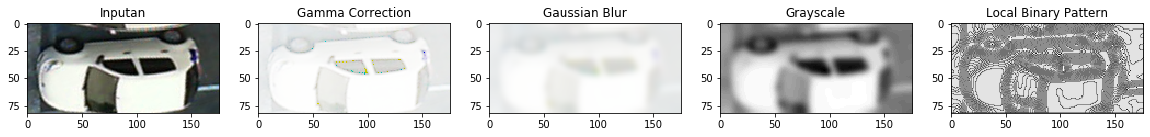

Hasil Prediksi : [1]


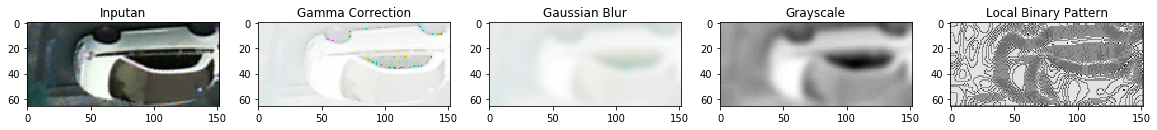

Hasil Prediksi : [1, 1]


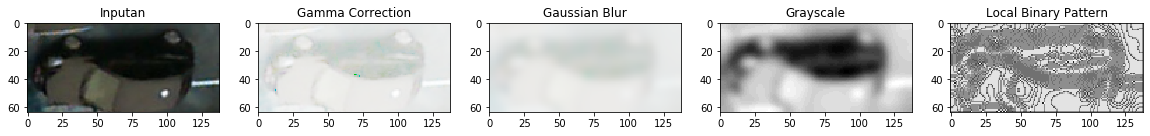

Hasil Prediksi : [1, 1, 1]


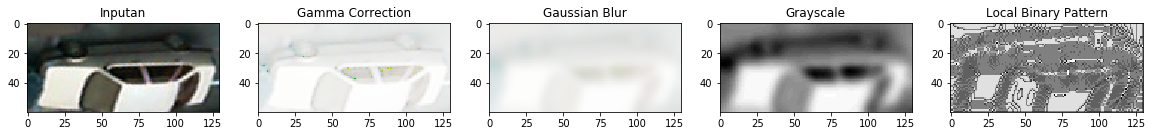

Hasil Prediksi : [1, 1, 1, 1]


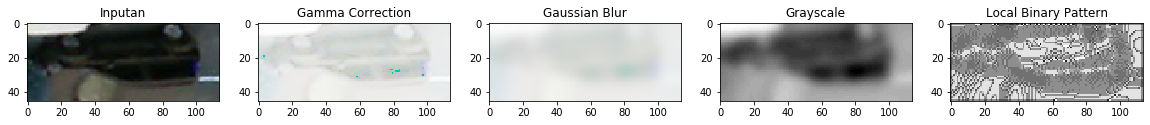

Hasil Prediksi : [1, 1, 1, 1, 1]


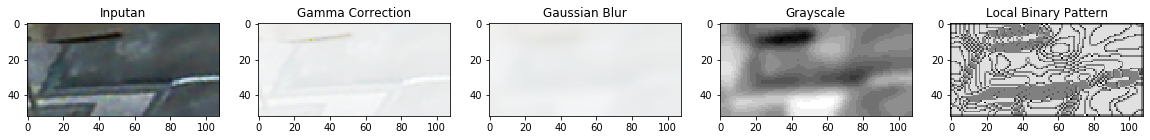

Slot Kosong  [6]
Hasil Prediksi : [1, 1, 1, 1, 1, 0]


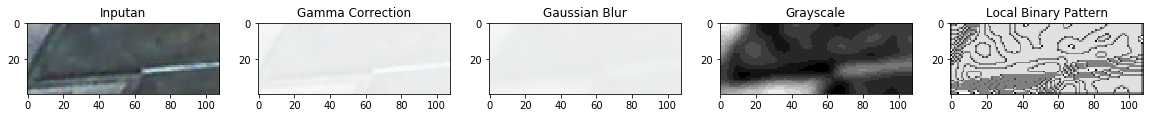

Slot Kosong  [6, 7]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0]


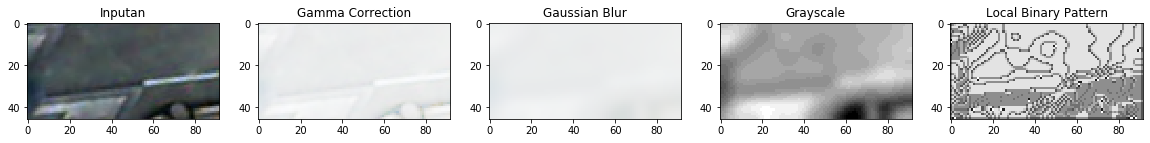

Slot Kosong  [6, 7, 8]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0]


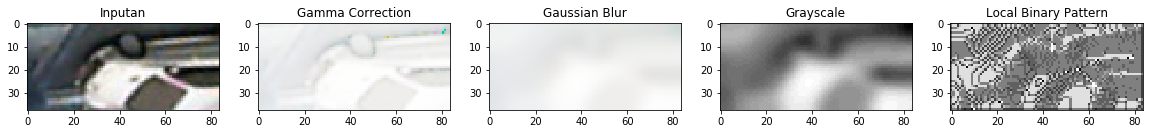

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1]


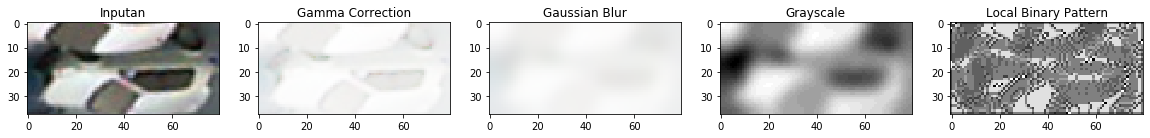

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1]


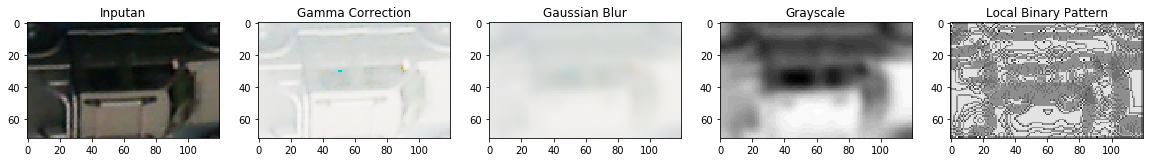

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]


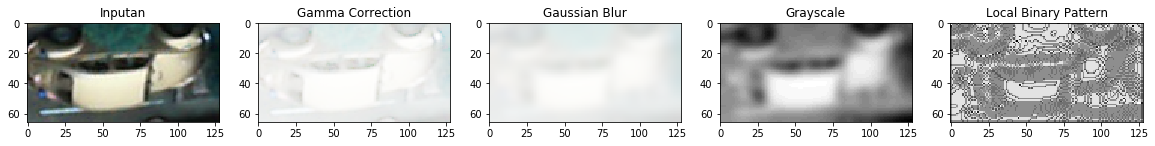

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]


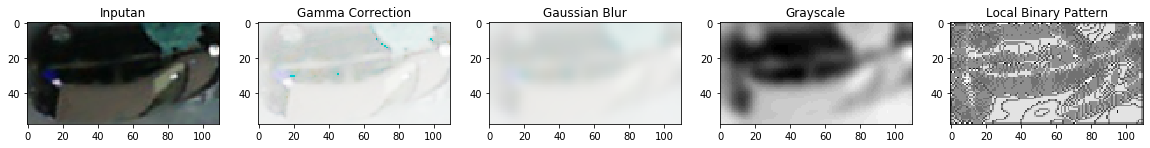

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


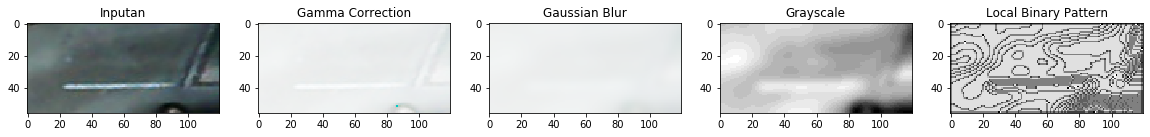

Slot Kosong  [6, 7, 8, 14]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]


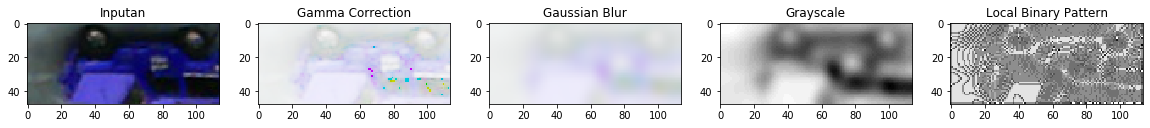

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]


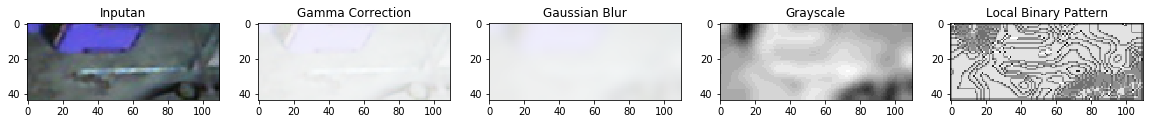

Slot Kosong  [6, 7, 8, 14, 16]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]


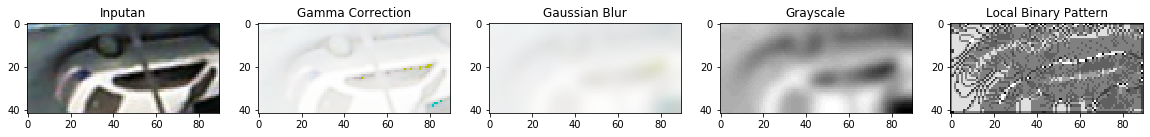

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]


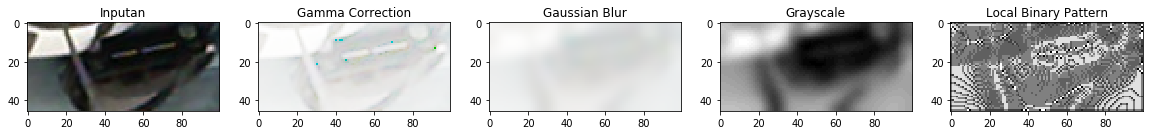

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]


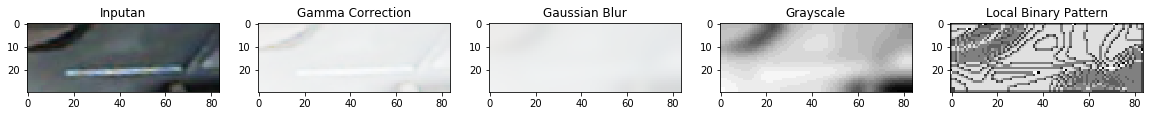

Slot Kosong  [6, 7, 8, 14, 16, 19]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]


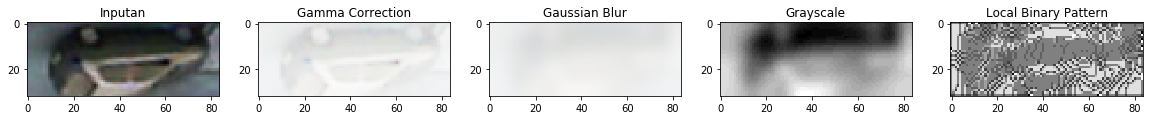

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]


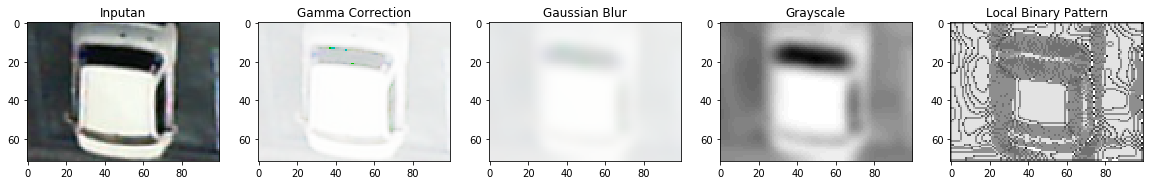

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]


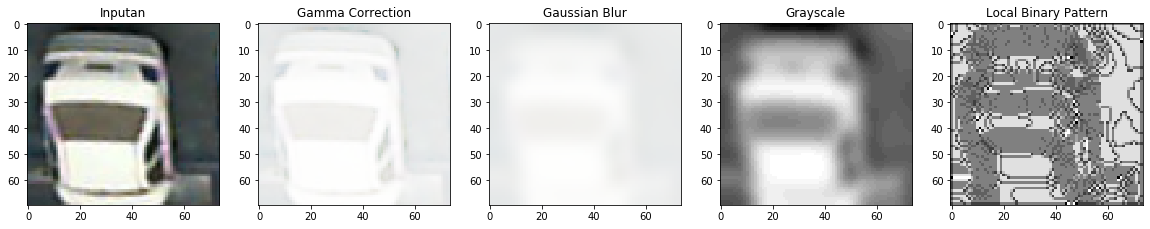

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]


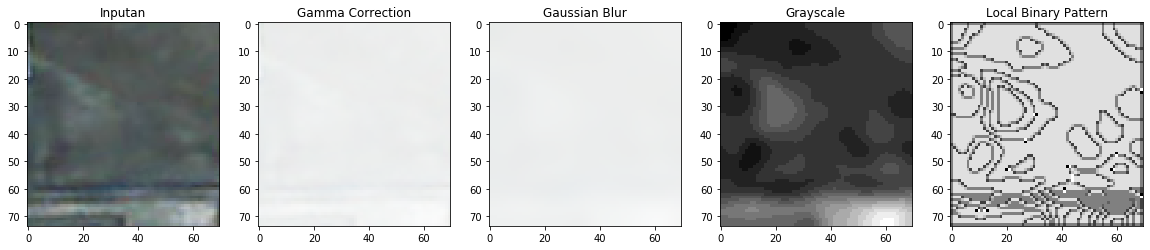

Slot Kosong  [6, 7, 8, 14, 16, 19, 23]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


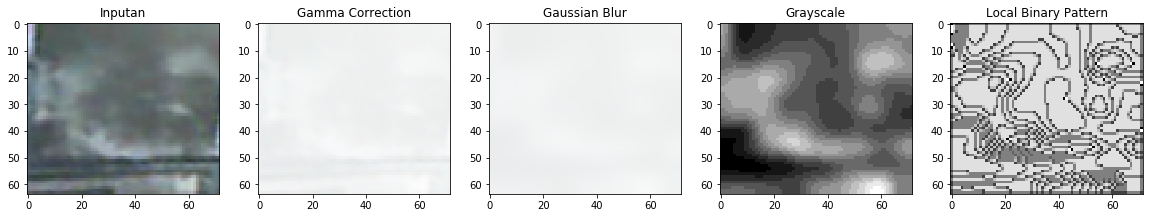

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]


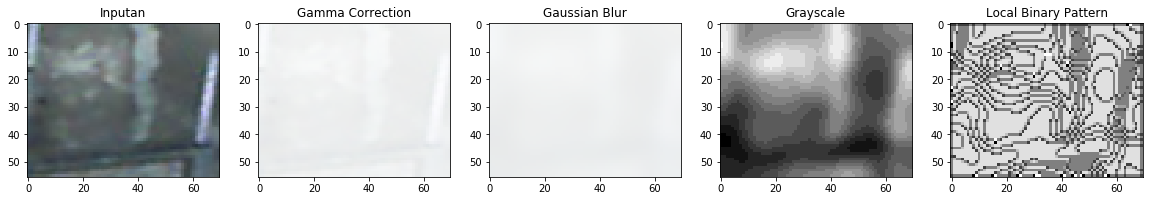

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]


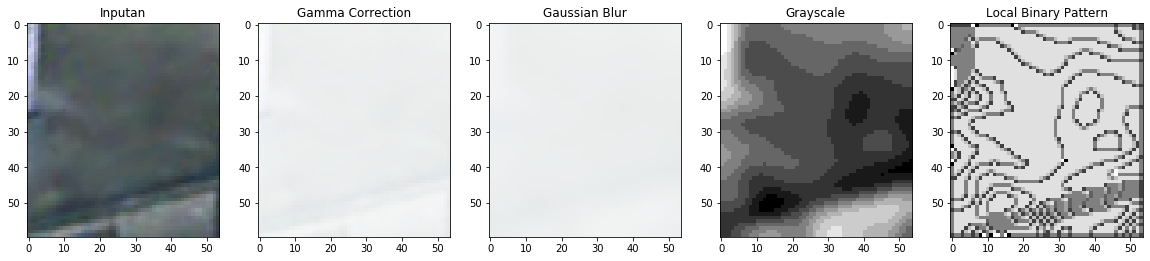

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]


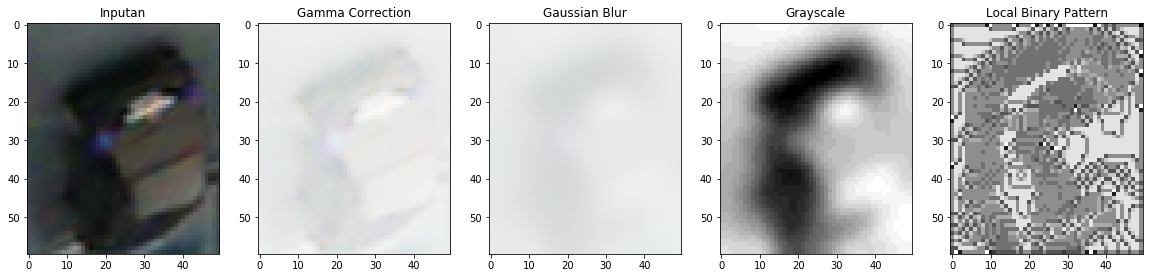

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]


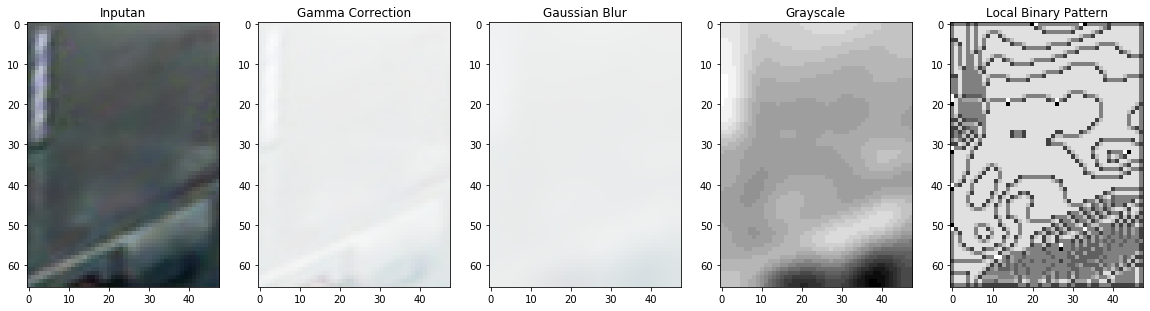

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]


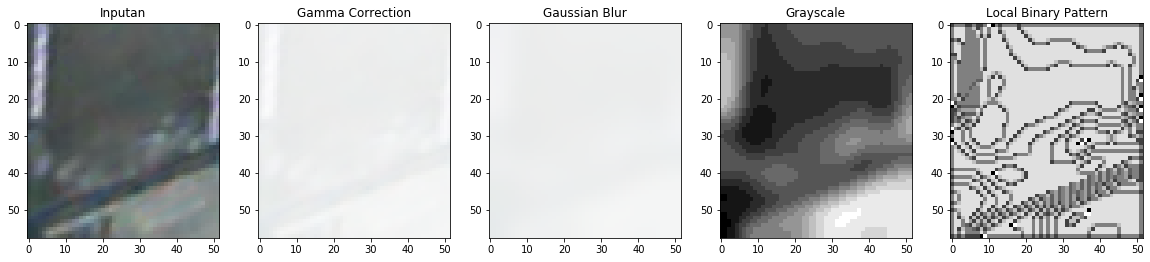

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28, 29]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]


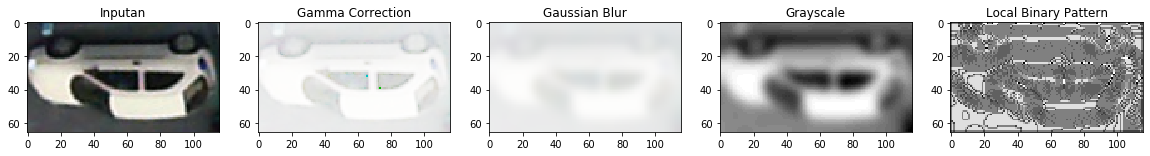

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]


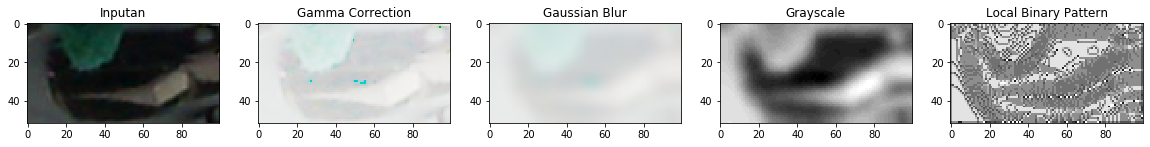

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]


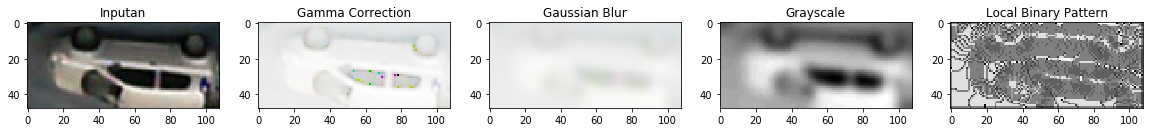

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]


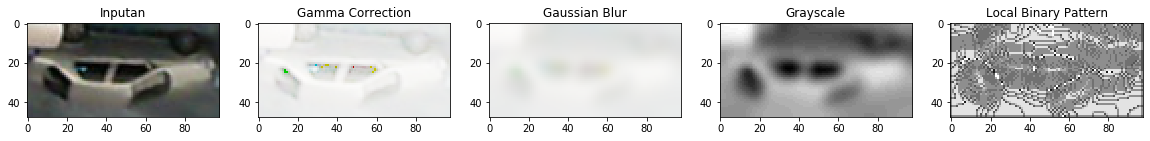

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]


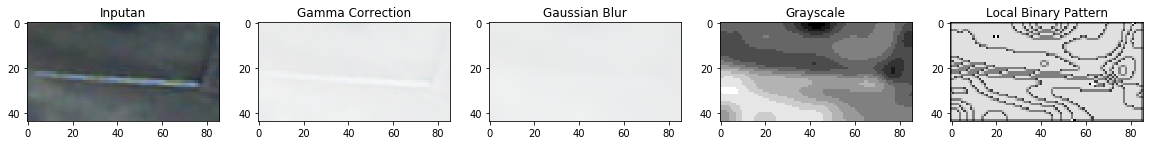

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28, 29, 34]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


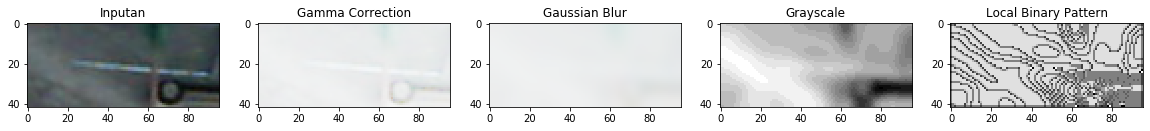

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28, 29, 34, 35]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]


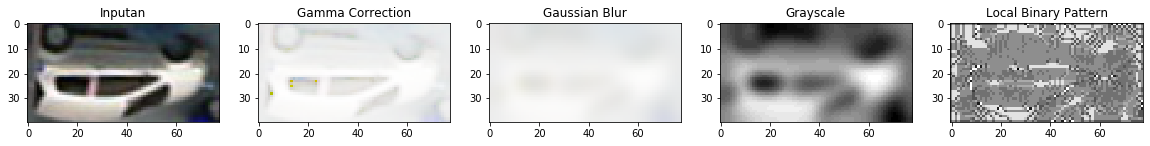

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]


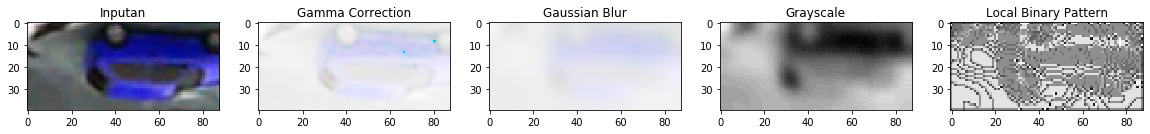

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]


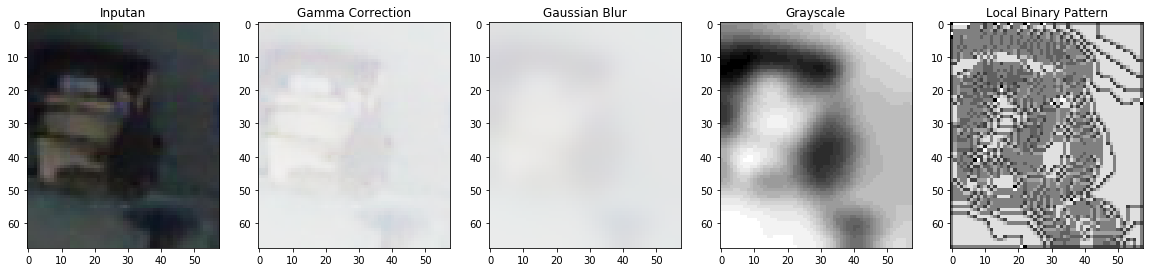

Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]


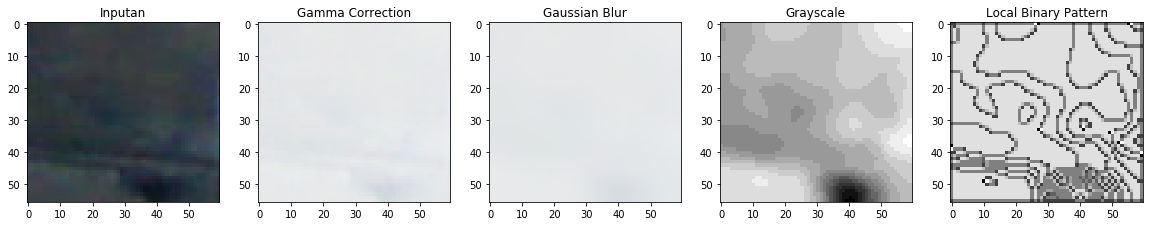

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28, 29, 34, 35, 39]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]


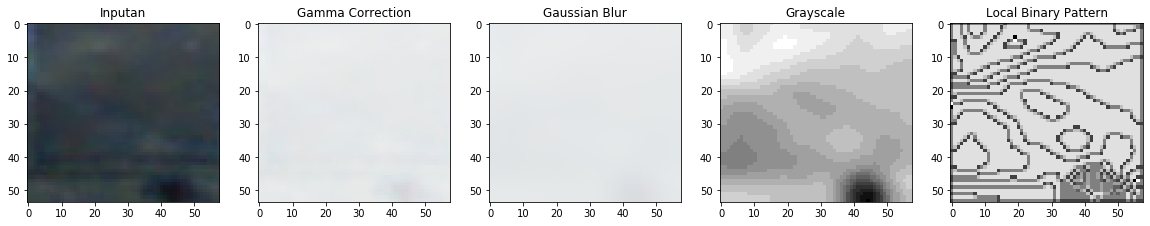

Slot Kosong  [6, 7, 8, 14, 16, 19, 23, 24, 25, 26, 28, 29, 34, 35, 39, 40]
Hasil Prediksi : [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]


True

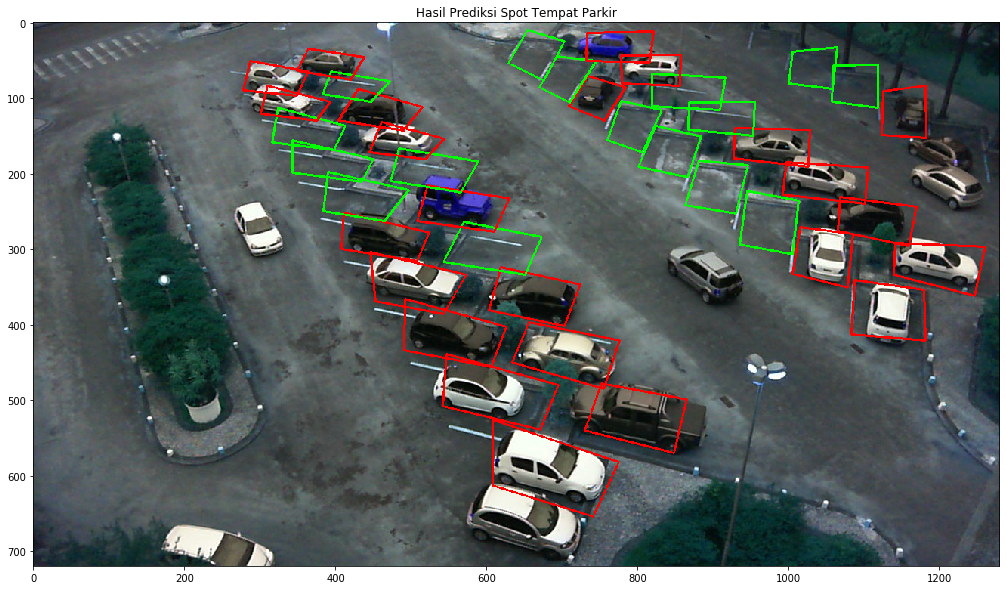

In [27]:
A = 0
I = 0
J = 0
TS = 0
FS = 0
Slot = 1
predictions = []
Slotcar = []
#Sunny/2013-02-24/2013-02-24_14_00_08.jpg #Data rusak
#Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05/Cloudy/Testing/2013-04-08/2013-04-08_17_46_44.jpg

for f_path in glob.glob("Z:/Pemrograman/TASmartParking/PKLot/PKLot/UFPR05/Testing/Cloudy/2013-02-22/2013-02-22_18_05_12.jpg"):
    print(f_path)
    I += 1
    dom1 = f_path[: -4] + ".xml"
    parking = get_points(dom1)
    N = len(parking["occupied"])
    if I > 1:
        continue
    #if I % 1 == 1:
    #if TS + FS > 0:
        #print("Processed " + str(I) + " . Accuracy: " + str(TS/(TS+FS)*100))
    for i, e in enumerate(parking["points"]):
        if J != N:
            pts = np.array(e, np.int32)
            tgt = np.array(parking["occupied"])
            img = cv2.imread(f_path)
            crop = rotate_crop_image(img,parking["rects"][J])
            cv2.imwrite('Z:/Pemrograman/TASmartParking/Result/Original/image_%d.jpg' % (A), crop)
            gamcor = adjust_gamma(crop, 15)
            cv2.imwrite('Z:/Pemrograman/TASmartParking/Result/Gamma Correction/image_%d.jpg' % (A), gamcor)
            #(r,g,b) = split(gamcor)
            #r = convolve(r, kernel)
            #g = convolve(g, kernel)
            #b = convolve(b, kernel)
            #blur = merge(r,g,b)
            blur = cv2.GaussianBlur(gamcor, None, 3)  
            cv2.imwrite('Z:/Pemrograman/TASmartParking/Result/Gaussian Blur/image_%d.jpg' % (A), blur)
            gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
            cv2.imwrite('Z:/Pemrograman/TASmartParking/Result/Grayscale/image_%d.jpg' % (A), gray)
            lbpu = desc.lbp(gray)
            f = plt.figure()
            f.add_subplot(1,5,1)
            plt.imshow(np.rot90(crop,2), cmap="gray")
            plt.title("Inputan")
            f.add_subplot(1,5,2)
            plt.imshow(np.rot90(gamcor,2))
            plt.title("Gamma Correction")
            f.add_subplot(1,5,3)
            plt.imshow(np.rot90(blur,2))
            plt.title("Gaussian Blur")
            f.add_subplot(1,5,4)
            plt.imshow(np.rot90(gray,2), cmap="gray")
            plt.title("Grayscale")
            f.add_subplot(1,5,5)
            plt.imshow(np.rot90(lbpu,2), cmap="gray")
            plt.title("Local Binary Pattern")
            plt.show(block=True)
            cv2.imwrite('Z:/Pemrograman/TASmartParking/Result/Local Binary Pattern/image_%d.jpg' % (A), lbpu)
            lbp = desc.describe(gray)
            newaxis = lbp[np.newaxis, :]
            d_selected = newaxis
            d_pred_svm = svm.predict(d_selected)#.astype(sp.float32), cv2.ml.ROW_SAMPLE)
            predictions.append(int(d_pred_svm))
            #cv2.polylines(img,[pts],True,(int((predictions[J])*255),int((1-predictions[J])*255),0),thickness=2)
            #cv2.putText(img, prediction[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0, 0, 255), 3)
            #plt.rcParams['figure.figsize'] = (20.0, 10.0)
            #plt.imshow(img)
            if (d_pred_svm[0] == 0 and tgt[J] == 0):
                Slotcar.append(Slot)
                print('Slot Kosong ',Slotcar)
            Slot += 1
            A += 1
            J += 1
            print('Hasil Prediksi :',predictions)

for i, e in enumerate(parking["points"]):
    pts = np.array(e, np.int32)
    spotted = cv2.polylines(img,[pts],True,(int((predictions[i])*255),int((1-predictions[i])*255),0),thickness=2)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.title("Hasil Prediksi Spot Tempat Parkir")
plt.imshow(img)
cv2.imwrite("spot parkir.jpg",img)